In [1]:
# Which python are we using?
import sys
sys.executable

'/Users/alex/opt/anaconda3/bin/python'

In [2]:
!python --version

Python 3.7.7


In [3]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium
import datetime
from ast import literal_eval

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
# %load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

In [4]:
# Absolute or relative path to processed instructor data that we want to analyse/map (REDASH)
instructors_file = "data/processed/redash_processed_carpentry_instructors_UK_2020-08-28.csv"

In [5]:
instructors_df = pd.read_csv(instructors_file, encoding = "utf-8")
instructors_df = instructors_df.drop(labels=['first_name', 'last_name'], axis=1)
# load 'taught_workshops_per_year' column as dictionary
instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: literal_eval(x))
instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: {})

In [6]:
# Let's change type of some columns and do some conversions

# Convert list of strings into list of dates for 'taught_workshop_dates' and 'earliest_badge_awarded' columns (turn NaN into [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].str.split(',')
instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), ['taught_workshop_dates']] = instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].apply(lambda list_str: [datetime.datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in list_str])

# Convert list of strings into list of dates for ' ' column (turn NaN into [])
instructors_df['taught_workshops'] = instructors_df['taught_workshops'].str.split(',')
instructors_df.loc[instructors_df['taught_workshops'].isnull(), ['taught_workshops']] = instructors_df.loc[instructors_df['taught_workshops'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])

# Convert 'earliest_badge_awarded' column from strings to datetime
instructors_df['earliest_badge_awarded'] = pd.to_datetime(instructors_df['earliest_badge_awarded'], format="%Y-%m-%d").apply(lambda x: x.date())
print(type(instructors_df['earliest_badge_awarded'][0]))

<class 'datetime.date'>


In [7]:
# Let's inspect our data
instructors_df.head(50)

,institution,institutional_region,normalised_institution,latitude,longitude,country,country_code,taught_workshops,taught_workshop_dates,taught_workshops_per_year,...,dc-instructor,lc-instructor,trainer,earliest_badge_awarded,year_earliest_badge_awarded,airport,airport_code,airport_latitude,airport_longitude,airport_region
0,University College London,London,University College London,51.524774,-0.133401,United Kingdom,GB,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",...,NaN,NaN,NaN,2017-12-08,2017,London Heathrow,LHR,51.477500,-0.461389,London
1,NaN,NaN,NaN,NaN,NaN,United Kingdom,GB,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},...,NaN,NaN,NaN,2014-11-27,2014,Exeter,EXT,50.734444,-3.413889,South West
2,University of Edinburgh,Scotland,University of Edinburgh,55.948003,-3.188111,United Kingdom,GB,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",...,2016-10-06,NaN,NaN,2014-12-23,2014,Edinburgh,EDI,55.950000,-3.372500,Scotland
3,University of Sussex,South East,University of Sussex,50.864464,-0.087049,United Kingdom,GB,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",...,2017-06-08,NaN,NaN,2017-06-08,2017,London Gatwick,LGW,51.148056,-0.190278,South East
4,University of Oxford,South East,University of Oxford,51.757644,-1.262868,United Kingdom,GB,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",...,2016-11-15,NaN,NaN,2014-05-09,2014,London Heathrow,LHR,51.477500,-0.461389,London
5,University of Manchester,NaN,University of Manchester,NaN,NaN,United Kingdom,GB,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",...,NaN,NaN,NaN,2019-01-07,2019,Manchester,MAN,53.353611,-2.274722,North West
6,"EPCC, University of Edinburgh",NaN,"EPCC, University of Edinburgh",NaN,NaN,United Kingdom,GB,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 3}",...,2016-01-27,NaN,NaN,2015-05-26,2015,Edinburgh,EDI,55.950000,-3.372500,Scotland
7,University of Edinburgh,Scotland,University of Edinburgh,55.948003,-3.188111,United Kingdom,GB,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",...,NaN,NaN,NaN,2014-07-22,2014,Edinburgh,EDI,55.950000,-3.372500,Scotland
8,British Trust for Ornithology,NaN,British Trust for Ornithology,NaN,NaN,United Kingdom,GB,[],[],{},...,NaN,NaN,NaN,2017-12-08,2017,Stansted,STN,51.885000,0.235000,Eastern
9,University of Cambridge,Eastern,University of Cambridge,52.205317,0.116642,United Kingdom,GB,[2017-01-18-CAM],[2017-01-18],{2017: 1},...,2016-11-11,NaN,NaN,2016-11-11,2016,Stansted,STN,51.885000,0.235000,Eastern


In [8]:
# Let's inspect our data a bit more
print("Columns: ")
print(instructors_df.columns)
print("\nData types: ")
print(instructors_df.dtypes)
print("\nExpecting a list for 'taught_workshop_dates' column: ")
print(type(instructors_df['taught_workshop_dates'][0]))
print("\nExpecting dates in the list in 'taught_workshop_dates' column: ")
print(instructors_df['taught_workshop_dates'][0])
print("\nExpecting datetime objects for 'earliest_badge_awarded' column: ")
print(type(instructors_df['earliest_badge_awarded'][0]))
print("\nExpecting datetime for 'earliest_badge_awarded' column: ")
print(instructors_df['earliest_badge_awarded'][0])
print("\n'earliest_badge_awarded' column should not have nulls:")
print(instructors_df[instructors_df['earliest_badge_awarded'].isnull()])

Columns: 
Index(['institution', 'institutional_region', 'normalised_institution',
       'latitude', 'longitude', 'country', 'country_code', 'taught_workshops',
       'taught_workshop_dates', 'taught_workshops_per_year', 'domains',
       'badges', 'badges_dates', 'swc-instructor', 'dc-instructor',
       'lc-instructor', 'trainer', 'earliest_badge_awarded',
       'year_earliest_badge_awarded', 'airport', 'airport_code',
       'airport_latitude', 'airport_longitude', 'airport_region'],
      dtype='object')

Data types: 
institution                     object
institutional_region            object
normalised_institution          object
latitude                       float64
longitude                      float64
country                         object
country_code                    object
taught_workshops                object
taught_workshop_dates           object
taught_workshops_per_year       object
domains                         object
badges                          object
ba

In [9]:
# How many instructors are there in total?
instructors_df.index.size

267

In [10]:
# instructors_df['earliest_badge_awarded']
# instructors_df['earliest_badge_awarded'] = instructors_df['earliest_badge_awarded'].apply(lambda date_str: datetime.datetime.strptime(date_str, '%Y-%m-%d').date())

In [11]:
# Get the date of the last taught workshop
instructors_workshops_df = pd.DataFrame(instructors_df[['taught_workshops', 'taught_workshop_dates', 'taught_workshops_per_year', 'earliest_badge_awarded']])
instructors_workshops_df['last_taught_workshop_date'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: max(x) if (x != []) else None)
instructors_workshops_df.head(10)

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-10-13
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-01-07,2019-10-21
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 3}",2015-05-26,2020-05-26
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-07-22,2014-02-18
8,[],[],{},2017-12-08,None
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2016-11-11,2017-01-18


In [12]:
# Extract column for each year containing number of workshops taught that year by instructor 
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for year in years: 
    instructors_workshops_df[year] = instructors_workshops_df['taught_workshops_per_year'].apply(lambda x: x.get(int(year), 0))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-10-13,0,2,1,3,3,2,1,4,3
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,"[2020-07-01-sfc-online, 2020-06-16-sfc-online]","[2020-07-01, 2020-06-16]",{2020: 2},2020-08-11,2020-07-01,0,0,0,0,0,0,0,0,2
263,[],[],{},2020-08-07,None,0,0,0,0,0,0,0,0,0
264,[],[],{},2020-08-19,None,0,0,0,0,0,0,0,0,0
265,[],[],{},2020-08-11,None,0,0,0,0,0,0,0,0,0


In [13]:
# Average number of workshop taught across all active years
instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df[years].replace(0, np.NaN).mean(axis=1)
# instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df['avarage_taught_workshops_per_year'].replace(np.NaN, 0)
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1,1.250
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0,2.000
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-10-13,0,2,1,3,3,2,1,4,3,2.375
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0,2.000
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,"[2020-07-01-sfc-online, 2020-06-16-sfc-online]","[2020-07-01, 2020-06-16]",{2020: 2},2020-08-11,2020-07-01,0,0,0,0,0,0,0,0,2,2.000
263,[],[],{},2020-08-07,None,0,0,0,0,0,0,0,0,0,NaN
264,[],[],{},2020-08-19,None,0,0,0,0,0,0,0,0,0,NaN
265,[],[],{},2020-08-11,None,0,0,0,0,0,0,0,0,0,NaN


In [14]:
# print(instructors_workshops_df.dtypes)
# print(instructors_workshops_df['taught_workshop_dates'][0])
# print(type(instructors_workshops_df['last_taught_workshop_date'][0]))
# print(instructors_workshops_df.index)
# instructors_workshops_df

In [15]:
# How many instructors taught 0 times?
len(instructors_workshops_df[instructors_workshops_df['last_taught_workshop_date'].isnull()].index)

105

In [16]:
# Let's define active and inactive instructors
# Active = taught in the past 2 years. Inactive = everyone else.
def is_active(taught_workshop_dates):
    if taught_workshop_dates == [] or (datetime.date.today() - max(taught_workshop_dates)).days > 712:
        return False
    else:
        return True
    
instructors_workshops_df['is_active'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: is_active(x))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year,is_active
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1,1.250,True
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0,2.000,False
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-10-13,0,2,1,3,3,2,1,4,3,2.375,True
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0,2.000,False
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0,1.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,"[2020-07-01-sfc-online, 2020-06-16-sfc-online]","[2020-07-01, 2020-06-16]",{2020: 2},2020-08-11,2020-07-01,0,0,0,0,0,0,0,0,2,2.000,True
263,[],[],{},2020-08-07,None,0,0,0,0,0,0,0,0,0,NaN,False
264,[],[],{},2020-08-19,None,0,0,0,0,0,0,0,0,0,NaN,False
265,[],[],{},2020-08-11,None,0,0,0,0,0,0,0,0,0,NaN,False


Number of active instructors: 102
Number of inactive instructors: 165


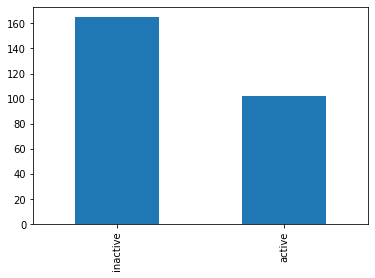

In [17]:
# How many active and inactive instructors?
active = instructors_workshops_df[instructors_workshops_df['is_active'] == True]
inactive = instructors_workshops_df[instructors_workshops_df['is_active'] != True]
print("Number of active instructors: " + str(len(active.index)))
print("Number of inactive instructors: " + str(len(inactive.index)))
active_vs_inactive = instructors_workshops_df['is_active'].value_counts()
active_vs_inactive.index = ['inactive', 'active']
plot = active_vs_inactive.plot(kind='bar')
# plot.set_xticklabels(['inactive', 'active'])

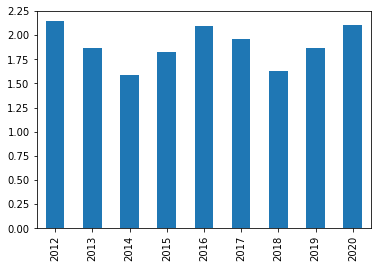

In [18]:
# Average number of workshops taught per year (for all instructors)
average_workshops_per_year_all = instructors_workshops_df[years].replace(0, np.NaN).mean(axis=0)
average_workshops_per_year_all.plot(kind='bar')

In [19]:
# Average number of workshops taught across all active years (for all instructors)
average_workshops_per_year_all.mean()

1.897325915855848

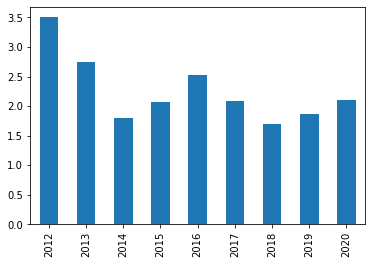

In [20]:
# Average number of workshops taught per year (for active instructors only)
average_workshops_per_year_active = active[years].replace(0, np.NaN).mean(axis=0)
average_workshops_per_year_active.plot(kind='bar')

In [21]:
# Average number of workshops taught across all active years (for active instructors only)
average_workshops_per_year_active.mean()

2.2677251291670237

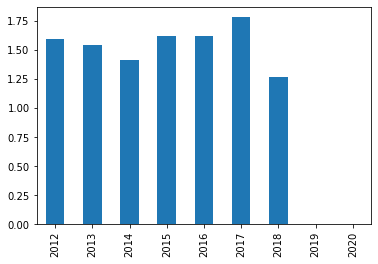

In [22]:
# Average number of workshops taught per year (for inactive instructors only)
average_workshops_per_year_inactive = inactive[years].replace(0, np.NaN).mean(axis=0)
average_workshops_per_year_inactive = average_workshops_per_year_inactive.replace(np.nan, 0)
average_workshops_per_year_inactive.plot(kind='bar')

In [23]:
# Average number of workshops taught across all active years (for inactive instructors only)
average_workshops_per_year_inactive.mean()

1.207495242277851

In [24]:
# How long have instructors that are inactive now been active for? 
# In other words, how long do they teach before they become inactive?
def activity_days_for_inactive(date_list):
    return (max(date_list) - min(date_list)).days

print("Number of inactive instructors: " + str(len(inactive.index)))
time_before_inactivity = inactive[inactive['taught_workshop_dates'].apply(lambda x: len(x)) > 0]# exclude instructors that taught 0 workshops
print("Number of inactive instructors that taught at least 1 workshop: " + str(len(time_before_inactivity.index)))
time_before_inactivity = time_before_inactivity['taught_workshop_dates'].apply(lambda x: activity_days_for_inactive(x))
time_before_inactivity = time_before_inactivity.replace(0, np.NaN)
print("\nAverage period of teaching activity (for currently inactive instructors that taught at least 1 workshop): " + str(time_before_inactivity.mean()) + " days.")

Number of inactive instructors: 165
Number of inactive instructors that taught at least 1 workshop: 60

Average period of teaching activity (for currently inactive instructors that taught at least 1 workshop): 473.7567567567568 days.


In [25]:
# How long have instructors that are active now been active for? 
# In other words, what is the current period of activity for active instuctors up to now
def activity_days_for_active(date_list):
    return (datetime.date.today() - min(date_list)).days
    
period_of_activity = active['taught_workshop_dates'].apply(lambda x: activity_days_for_active(x))
print("Number of active instructors: " + str(len(period_of_activity.index)))
period_of_activity = period_of_activity.replace(0, np.NaN)
print("\nAverage period of teaching activity up till now (for currently active instructors): " + str(period_of_activity.mean()) + " days.")

Number of active instructors: 102

Average period of teaching activity up till now (for currently active instructors): 928.7058823529412 days.


In [26]:
# How long have all instructors been active for on average? 
# In other words, what is the period of teaching activity for all instuctors
period_of_activity_all = instructors_workshops_df[instructors_workshops_df['taught_workshop_dates'].apply(lambda x: len(x) > 0)]# exclude instructors that taught 0 workshops
print("Number of active and inactive instructors (that taught at least 1 workshop): " + str(len(period_of_activity_all.index)))
period_of_activity_all = period_of_activity_all.apply(lambda x: activity_days_for_active(x['taught_workshop_dates']) if x['is_active'] else activity_days_for_inactive(x['taught_workshop_dates']), axis = 1)
period_of_activity_all = period_of_activity_all.replace(0, np.NaN)
print("\nAverage period of teaching activity (for all instructors that taught at least 1 workshop): " + str(period_of_activity_all.mean()) + " days.")
# period_of_activity_all

Number of active and inactive instructors (that taught at least 1 workshop): 162

Average period of teaching activity (for all instructors that taught at least 1 workshop): 807.6043165467626 days.


In [27]:
# How long from becoming an instructor to teaching for the first time on average?
def time_before_first_workshop(date, dates_list):
    if dates_list != []:
        days = min(dates_list) - date
        if days.days > 0: # disregard those instructors who were teaching before officially qualifying as instructors
            return days.days
    return np.NaN
    
instructors_workshops_df['days_to_first_workshop'] = instructors_workshops_df.apply(lambda x: time_before_first_workshop(x['earliest_badge_awarded'], x['taught_workshop_dates']), axis=1)
print("\nAverage period between becoming an instructor and teaching for the first time: " + str(instructors_workshops_df['days_to_first_workshop'].mean()) + " days.")


Average period between becoming an instructor and teaching for the first time: 191.30263157894737 days.


      number_of_instructors
year                       
2012                      5
2013                     10
2014                     22
2015                     21
2016                     25
2017                     46
2018                     41
2019                     64
2020                     33


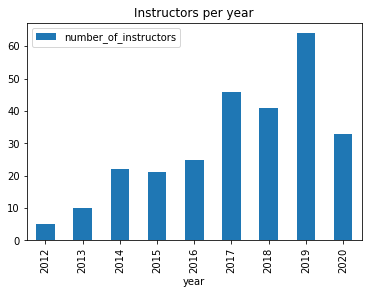

In [28]:
# How many new instructors are there for each year?
instructors_per_year = instructors_df['year_earliest_badge_awarded'].value_counts()
instructors_per_year.sort_index(ascending = True, inplace=True)
instructors_per_year.index.name = 'year'
instructors_per_year = instructors_per_year.to_frame('number_of_instructors')
print(instructors_per_year)
instructors_per_year.plot(kind='bar', legend=True, title ="Instructors per year")

      number_of_workshops
2012                    7
2013                   14
2014                   21
2015                   32
2016                   43
2017                   54
2018                   66
2019                   89
2020                   15


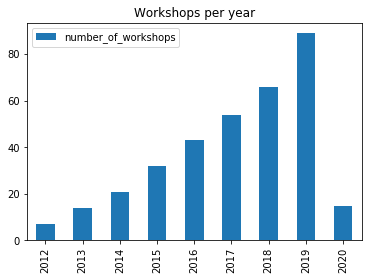

In [29]:
# Let's look how many workshops are these instructors teaching per year?
workshops_file = "data/processed/redash_processed_carpentry_workshops_UK_2020-04-09.csv"
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")

workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
workshops_per_year.index = workshops_per_year.index.astype('int64') 
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

Imperial College London                                26
University of Edinburgh                                18
University College London                              18
University of Oxford                                   15
University of Leeds                                    13
                                                       ..
Thales                                                  1
Bill Lyons Informatics Centre, UCL Cancer Institute     1
Simon Fraser University (SFU)                           1
University of Liverpool                                 1
EPCC, The University of Edinburgh                       1
Name: normalised_institution, Length: 89, dtype: int64


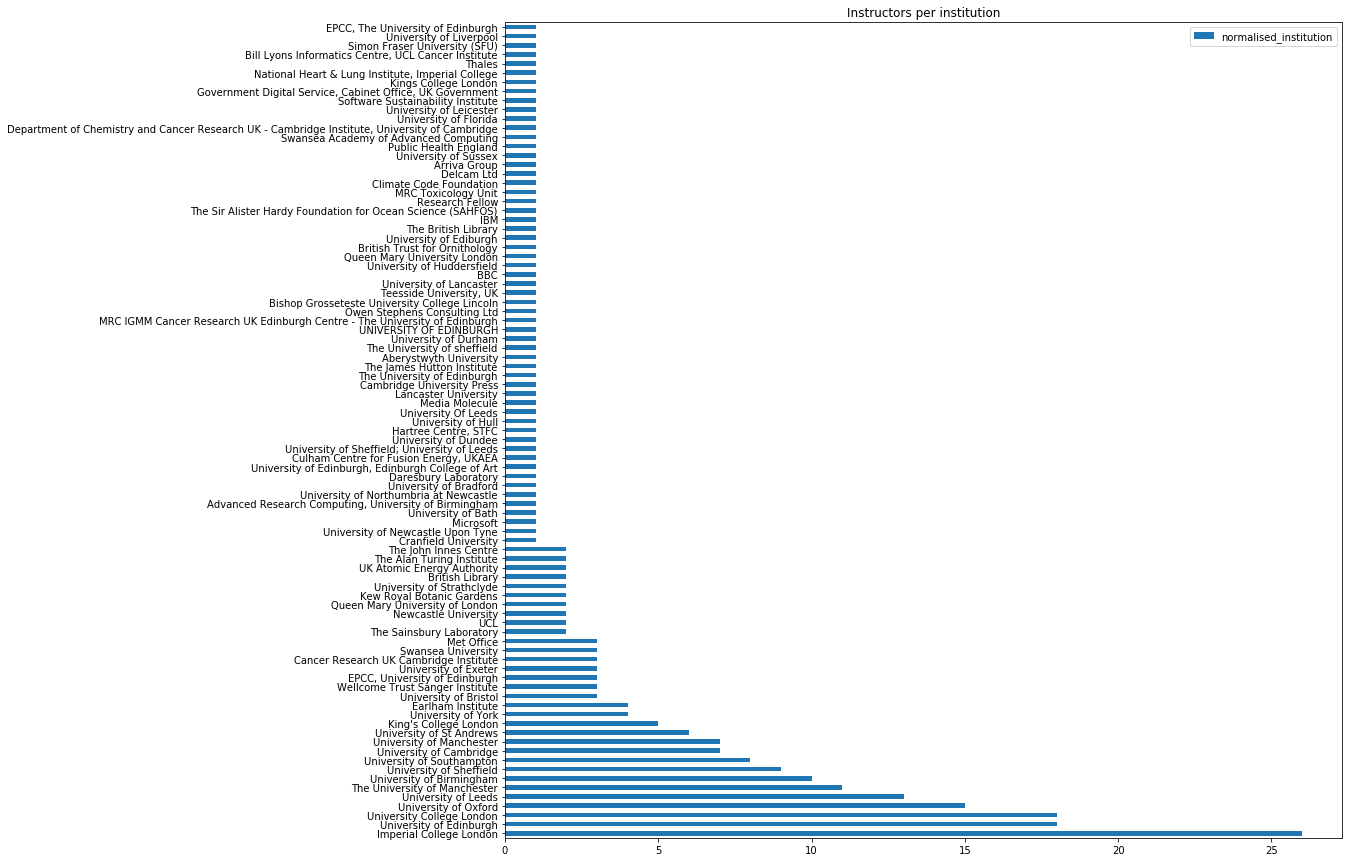

In [30]:
# How many instructors are there at each institution?
instructors_per_institution = instructors_df['normalised_institution'].value_counts()
print(instructors_per_institution)
instructors_per_institution.plot(kind='barh', legend=True, title ="Instructors per institution", figsize = (15,15))

In [31]:
# How many instructors do we not have normalised institution for?
instructors_df['normalised_institution'].isnull().sum()

8

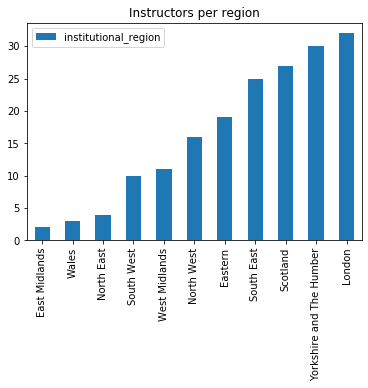

In [32]:
# How are instructors spread over UK regions based on their affiliations?
instructors_per_region = instructors_df['institutional_region'].value_counts()
instructors_per_region.sort_values(inplace=True)
instructors_per_region.plot(kind='bar', legend=True, title ="Instructors per region")

In [33]:
# How many instructors do we not have region for?
instructors_df['institutional_region'].isnull().sum()

88

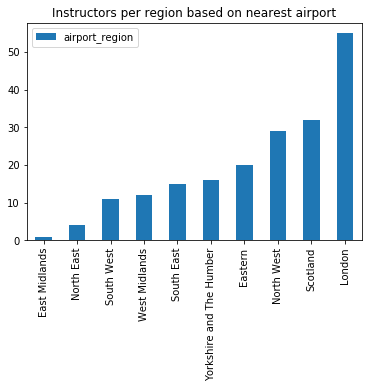

In [34]:
# How are instructors spread over UK regions based on the nearest airpor?
instructors_per_region_nearest_airport = instructors_df['airport_region'].value_counts()
instructors_per_region_nearest_airport.sort_values(inplace=True)
instructors_per_region_nearest_airport.plot(kind='bar', legend=True, title ="Instructors per region based on nearest airport")

In [35]:
# How many insructors do we not have regions based on the nearest airport?
instructors_df['airport_region'].isnull().sum()

72

In [36]:
# Let's merge region info - if we have institutional region - use that, if not - use airport reqion, else leave blank
instructors_df['region'] = instructors_df.apply(
    lambda x: x['institutional_region'] if pd.notnull(x['institutional_region']) else x['airport_region'],
    axis=1)
# How many instructors do we not have region for now?
print("No region info for " + str(instructors_df['region'].isnull().sum()) + ' instructors')
instructors_df[['institutional_region','airport_region', 'region']].head(50)

No region info for 32 instructors


,institutional_region,airport_region,region
0,London,London,London
1,NaN,South West,South West
2,Scotland,Scotland,Scotland
3,South East,South East,South East
4,South East,London,South East
5,NaN,North West,North West
6,NaN,Scotland,Scotland
7,Scotland,Scotland,Scotland
8,NaN,Eastern,Eastern
9,Eastern,Eastern,Eastern


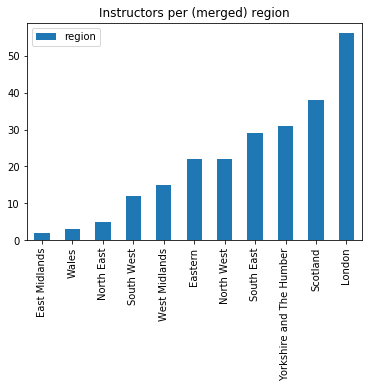

In [37]:
instructors_per_region_merged = instructors_df['region'].value_counts()
instructors_per_region_merged.sort_values(inplace=True)
instructors_per_region_merged.plot(kind='bar', legend=True, title ="Instructors per (merged) region")

In [41]:
# # Let's do a choropleth map of instructors per UK regions
#uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
#instructors_map = helper.generate_choropleth_map(instructors_df, uk_regions, "instructors")
# instructors_map

NameError: name 'uk_regions' is not defined

In [39]:
# A clustered map of all instructor affiliaiton locations
# Add column 'description' which is used for popups in maps
instructors_df['popup'] = instructors_df["institution"]
instructors_map = helper.generate_map_with_clustered_markers(instructors_df.dropna(subset=['longitude', 'latitude']))
instructors_map

In [40]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

instructors_file_name = os.path.basename(instructors_file)
instructors_file_name_without_extension = re.sub('\.csv$', '', instructors_file_name.strip())
instructors_analyses_excel_file = ANALYSES_DIR + "analysed_" + instructors_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(instructors_analyses_excel_file, engine='xlsxwriter')

instructors_df.to_excel(excel_writer, sheet_name="carpentry_instructors", index=False)

# Instructors per year
instructors_per_year.to_excel(excel_writer, sheet_name='instructors_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['instructors_per_year', 1, 0, len(instructors_per_year.index), 0],
        'values': ['instructors_per_year', 1, 1, len(instructors_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per year'})
worksheet.insert_chart('I2', chart)

# Instructors per institution
instructors_per_institution.to_excel(excel_writer, sheet_name='instructors_per_institution', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_institution']
chart = workbook.add_chart({'type': 'bar'})
chart.add_series({
        'categories': ['instructors_per_institution', 1, 0, len(instructors_per_institution.index), 0],
        'values': ['instructors_per_institution', 1, 1, len(instructors_per_institution.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per host'})
worksheet.insert_chart('I2', chart)

# Instructors per region
instructors_per_region_merged.to_excel(excel_writer, sheet_name='instructors_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_region']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['instructors_per_region', 1, 0, len(instructors_per_region_merged.index), 0],
        'values': ['instructors_per_region', 1, 1, len(instructors_per_region_merged.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Region institution'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per region'})
worksheet.insert_chart('I2', chart)

# Active vs inactive
active_vs_inactive.to_excel(excel_writer, sheet_name='active_vs_inactive', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['active_vs_inactive']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['active_vs_inactive', 1, 0, len(active_vs_inactive.index), 0],
        'values': ['active_vs_inactive', 1, 1, len(active_vs_inactive.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Activity type'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Active vs inactive instructors'})
worksheet.insert_chart('I2', chart)

# Workshops taught per year
average_workshops_per_year = pd.concat([average_workshops_per_year_all, average_workshops_per_year_active, average_workshops_per_year_inactive], axis=1)
average_workshops_per_year.columns = ['all', 'active', 'inactive']
average_workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(average_workshops_per_year_all.index), 0],
        'values': ['workshops_per_year', 1, 1, len(average_workshops_per_year_all.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops taught', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Average workshops taught per year for all instructors'})
worksheet.insert_chart('I2', chart)
chart = workbook.add_chart({'type': 'column'})
# category/value:    [sheetname, first_row, first_col, last_row, last_col]
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(average_workshops_per_year_active.index), 0],
        'values': ['workshops_per_year', 1, 2, len(average_workshops_per_year_active.index), 2],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops taught', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Average workshops taught per year for active instructors'})
worksheet.insert_chart('I22', chart)
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(average_workshops_per_year_inactive.index), 0],
        'values': ['workshops_per_year', 1, 3, len(average_workshops_per_year_inactive.index), 3],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops taught', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Average workshops taught per year for inactive instructors'})
worksheet.insert_chart('I42', chart)


# Period of activity
workbook = excel_writer.book
worksheet = workbook.add_worksheet('instructor_activity')
worksheet.write(0, 0, "Number of active instructors: " + str(len(period_of_activity.index)))
worksheet.write(1, 0, "Average period of teaching activity up till now (for currently active instructors): " + str(period_of_activity.mean()) + " days.")

worksheet.write(3, 0, "Number of inactive instructors: " + str(len(inactive.index)))
worksheet.write(4, 0, "Number of inactive instructors that taught at least 1 workshop: " + str(len(time_before_inactivity.index))) 
worksheet.write(5, 0, "Average period of teaching activity (for currently inactive instructors that taught at least 1 workshop): " + str(time_before_inactivity.mean()) + " days.") 

worksheet.write(7, 0, "Number of active and inactive instructors (that taught at least 1 workshop): " + str(len(period_of_activity_all.index)))
worksheet.write(8, 0, "\nAverage period of teaching activity (for all instructors that taught at least 1 workshop): " + str(period_of_activity_all.mean()) + " days.") 
 
worksheet.write(10, 0, "Average number of workshops taught across all active years (for active instructors): " + str(average_workshops_per_year_active.mean()))
worksheet.write(11, 0, "Average number of workshops taught across all active years (for inactive instructors): " + str(average_workshops_per_year_inactive.mean()))


excel_writer.save()
print("Saved instructors analyses in " + instructors_analyses_excel_file)

Saved instructors analyses in data/analyses/analysed_redash_processed_carpentry_instructors_UK_2020-08-28_from_ipynb.xlsx
